<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [1]:
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy

from bs4 import BeautifulSoup

## 1) *Clean:* Job Listings from indeed.com that contain the title "Data Scientist" 

You have `job_listings.csv` in the data folder for this module. The text data in the description column is still messy - full of html tags. Use the [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library to clean up this column. You will need to read through the documentation to accomplish this task. 

In [2]:
from bs4 import BeautifulSoup
import requests
job_list = pd.read_csv("./data/job_listings.csv")

description = []
for i in job_list['description']:
    soup = BeautifulSoup(i, 'html.parser')
    clean_soup = re.sub('["\']', ' ', soup.get_text())
    clean_soup = clean_soup.replace("\\n", ' ')
    description.append(clean_soup)

job_list['description'] = description

job_list.head()

,Unnamed: 0,description,title
0,0,b Job Requirements: Conceptual understanding i...,Data scientist
1,1,"b Job Description As a Data Scientist 1, you ...",Data Scientist I
2,2,b As a Data Scientist you will be working on c...,Data Scientist - Entry Level
3,3,"b $4,969 - $6,756 a monthContractUnder the gen...",Data Scientist
4,4,b Location: USA \xe2\x80\x93 multiple location...,Data Scientist


## 2) Use Spacy to tokenize the listings 

In [16]:
import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load("en_core_web_lg")
tokenizer = Tokenizer(nlp.vocab)

DS_STOP_WORDS = ['data', ' ', 'b', 'Data', 'science', 'Science', 'scientist']

# Tokenizer Pipe
tokens = []
for doc in tokenizer.pipe(job_list['description'], batch_size=500):
    doc_tokens = [token.lower_.strip() for token in doc if ((token.is_stop != True) and (token.is_punct != True) and (token.text not in DS_STOP_WORDS))]
    tokens.append(doc_tokens)

job_list['tokens'] = tokens
job_list.head()

,Unnamed: 0,description,title,tokens
0,0,b Job Requirements: Conceptual understanding i...,Data scientist,"[job, requirements:, conceptual, understanding..."
1,1,"b Job Description As a Data Scientist 1, you ...",Data Scientist I,"[job, description, scientist, 1,, help, build,..."
2,2,b As a Data Scientist you will be working on c...,Data Scientist - Entry Level,"[scientist, working, consulting, business., re..."
3,3,"b $4,969 - $6,756 a monthContractUnder the gen...",Data Scientist,"[$4,969, $6,756, monthcontractunder, general, ..."
4,4,b Location: USA \xe2\x80\x93 multiple location...,Data Scientist,"[location:, usa, \xe2\x80\x93, multiple, locat..."


## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(stop_words='english', max_features=5000, ngram_range=(1,3)) 

data = job_list['description']

#Learn our Vocab
vect.fit(data)
# Get sparse dtm
dtm = vect.transform(data)

dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())
dtm.head()

,000,000 employees,10,10 years,100,100 000,11,12,12 months,15,...,years work experience,years working,years xe2,years xe2 x80,yes,york,york city,yrs,zf,zillow
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 4) Visualize the most common word counts

In [18]:
from collections import Counter

def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False) 
        #https://pandas.pydata.org/pandas-docs/version/0.24.2/reference/api/pandas.DataFrame.rank.html
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [19]:
wc = count(job_list['tokens'])

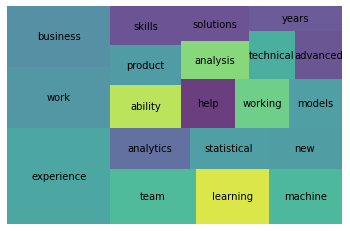

In [20]:
import squarify
import matplotlib.pyplot as plt

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

data = job_list['description']


# Instantiate vectorizer object
tfidf = TfidfVectorizer(stop_words='english', 
                        ngram_range=(1,2),
                        max_features=2000, # added later
                        max_df=.97,
                        min_df=3)
#                         tokenizer=tokenize)

# Create a vocabulary and get word counts per job_listing
# Similiar to fit_predict
dtm = tfidf.fit_transform(data)

# Print word counts

# Get feature names to use as dataframe column headers
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

# View Feature Matrix as DataFrame
dtm.head()

,000,10,100,12,12 months,20,2019,25,40,401,...,year experience,years,years experience,years hands,years industry,years professional,years relevant,years work,years xe2,york
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.099616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [27]:
# Fit a NearestNeighbor Model

from sklearn.neighbors import NearestNeighbors

# Fit on DTM
nn = NearestNeighbors(n_neighbors=8, algorithm='kd_tree') #n_neighbors=5 upgraded to 8
nn.fit(dtm)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=8, p=2,
                 radius=1.0)

In [30]:
my_ideal_job = [''' 
Data Science analysis math people person team work presentation speaker
''']

In [31]:
# Query for My Ideal Job
new = tfidf.transform(my_ideal_job)

In [33]:
# vector has shape of 1, 2000
new.todense().shape

(1, 2000)

In [34]:
# this gives up the nearest neighbors
nn.kneighbors(new.todense())

(array([[1.29999115, 1.30972505, 1.30972505, 1.31563189, 1.31947238,
         1.32202522, 1.32430585, 1.32554549]]),
 array([[  2, 252, 192, 418, 401, 176, 301, 297]]))

In [35]:
data[2][:200] 

'b As a Data Scientist you will be working on consulting side of our business. You will be responsible for analyzing large, complex datasets and identify meaningful patterns that lead to actionable rec'

In [36]:
data[252][:200] 

'b InternshipPosition Description The candidate will work along side data scientists / engineers in the team to work on challenging machine learning problems and explore how state-of-the-art machine le'

In [37]:
data[192][:200] 

'b InternshipPosition Description The candidate will work along side data scientists / engineers in the team to work on challenging machine learning problems and explore how state-of-the-art machine le'

In [38]:
data[418][:200] 

'b ContractThe role is largely operational and supports product and pricing analytics activities in Product and Analytics team. Work with segment managers to deep dive on biz performance; deliver prese'

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 